In [31]:
# %pip install langgraph
# %pip install python-dotenv
# %pip install langchain
# %pip install langchain-groq
# %pip install langchain_tavily

In [1]:
import os
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [ ]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(api_key=os.environ.get("GROQ_API"), model='llama3-8b-8192')

In [4]:
def chatbot(state: State):
    return {"messages":[llm.invoke(state["messages"])]}

In [5]:
graph_builder.add_node("llmchatbot", chatbot)
graph_builder.add_edge(START, "llmchatbot")
graph_builder.add_edge("llmchatbot", END)

graph=graph_builder.compile()

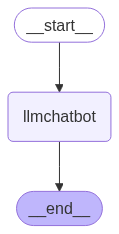

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [7]:
response = graph.invoke({"messages":"Hi"})
response["messages"][-1].content

"Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [8]:
for event in graph.stream({"messages":"Hi how are you"}):
    for value in event.values():
        print(value["messages"][-1].content)

Hi! I'm just an AI, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to help with any questions or tasks you have! How about you? How's your day going so far?


In [10]:
from langchain_tavily import TavilySearch

tool = TavilySearch(tavily_api_key= os.environ.get("TAVILY_API"), max_results=2)
tool.invoke("What is AI?")

{'query': 'What is AI?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Artificial intelligence - Wikipedia',
   'url': 'https://en.wikipedia.org/wiki/Artificial_intelligence',
   'content': 'Artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making.It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to',
   'score': 0.93161833,
   'raw_content': None},
  {'title': 'Artificial intelligence (AI) | Definition, Examples, Types ...',
   'url': 'https://www.britannica.com/technology/artificial-intelligence',
   'content': '[artificial intelligence](https://www.britannica.com/technology/artificial-intelligence) [References & Edit History](https://www.britannica.com/technology/a

In [21]:
def multiply(a:int,b:int) -> int:
    """Multiply a and b

    Args:
        a (int) : first int
        b (int) : second int

    Returns:
        int: output int
    
    """
    return a*b

In [22]:
tools = [tool, multiply]

In [23]:
llm_with_tools=llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001A4BFFC8E50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001A4C0125090>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list 

In [24]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def tool_calling_llm(state: State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition                     
)
builder.add_edge("tools", END)

graph = builder.compile()

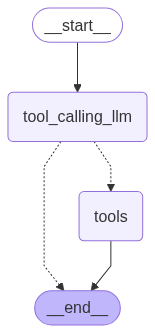

In [25]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [18]:
response = graph.invoke({"messages": "What is the recent news in Israel Iran war?"})
response['messages'][-1].content

'{"query": "recent news Israel Iran war", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.washingtonpost.com/world/2025/06/21/israel-iran-middle-east-strategic-balance/", "title": "Israeli strikes on Iran cap dramatic shift in Mideast strategic balance - The Washington Post", "score": 0.79637206, "published_date": "Sat, 21 Jun 2025 20:51:57 GMT", "content": "Israel has dealt a series of blows to Iran’s nuclear and military efforts in recent years, engaging in sabotage and assassinations. Then last year, for the first time, Iran and Israel began openly trading strikes, initially triggered by a fatal Israeli attack on the Iranian consulate in Damascus, Syria, and Israeli forces succeeded in knocking out key Iranian air defenses. Since the tensions erupted into full conflict this month, Israeli forces have killed senior military officials and nuclear", "raw_content": null}, {"url": "https://www.washingtonpost.com/world/2025/06/19/iran-israel-con

In [19]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent news in Israel Iran war?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (6e3s7xmh4)
 Call ID: 6e3s7xmh4
  Args:
    query: recent news Israel Iran war
    search_depth: advanced
    time_range: week
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent news Israel Iran war", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.washingtonpost.com/world/2025/06/21/israel-iran-middle-east-strategic-balance/", "title": "Israeli strikes on Iran cap dramatic shift in Mideast strategic balance - The Washington Post", "score": 0.79637206, "published_date": "Sat, 21 Jun 2025 20:51:57 GMT", "content": "Israel has dealt a series of blows to Iran’s nuclear and military efforts in recent years, engaging in sabotage and 

In [27]:
response = graph.invoke({"messages": "What is 2 multiply by 3 and then multiply by 10?"})
response['messages'][-1].content

'60'

In [28]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 multiply by 3 and then multiply by 10?
================================== Ai Message ==================================
Tool Calls:
  multiply (1r61ck0wf)
 Call ID: 1r61ck0wf
  Args:
    a: 2
    b: 3
  multiply (22y071vme)
 Call ID: 22y071vme
  Args:
    a: 6
    b: 10
================================= Tool Message =================================
Name: multiply

6
================================= Tool Message =================================
Name: multiply

60


In [30]:
def tool_calling_llm(state: State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition                     
)
builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile()

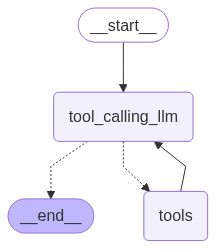

In [31]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [32]:
response = graph.invoke({"messages": "Give me recent updates about Israel Iran war and then mulitply 10*2"})
response['messages'][-1].content

'Based on the tool call id "7xbt0qzeh", the tool yielded recent updates about the Israel-Iran war. Here\'s a summary of the results:\n\n* The Guardian reported that US President Donald Trump declared a ceasefire in the 12-day war between Israel and Iran, and that Iran launched missiles on a US military facility in the Middle East.\n* The Institute for the Study of War reported that Iran had not conducted an attack on Israel since approximately 3:25 AM ET on June 24, and that Israel had not conducted an attack on Iran since approximately 7:35 AM ET on June 24.\n* The ceasefire between Iran and Israel appears to be holding despite both Israeli and Iranian claims of violations.\n\nNow, let\'s multiply 10*2:\n\n10 * 2 = 20'

In [33]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me recent updates about Israel Iran war and then mulitply 10*2
================================== Ai Message ==================================
Tool Calls:
  tavily_search (7xbt0qzeh)
 Call ID: 7xbt0qzeh
  Args:
    query: Israel Iran war latest news
    search_depth: advanced
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "Israel Iran war latest news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.theguardian.com/world/live/2025/jun/24/israel-iran-war-live-updates-trump-declares-ceasefire-tehran-attack-us-base-qatar", "title": "Israel-Iran war live: Trump declares ceasefire in ‘12-day war’; IDF reports Iranian missile launches - The Guardian", "score": 0.8646883, "published_date": "Tue, 24 Jun 2025 03:05:11 GMT", "content": "It has been a dramatic few hou

In [34]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

def tool_calling_llm(state: State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition                     
)
builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile(checkpointer=memory)

In [35]:
config={"configurable": {"thread_id": "1"}}

response = graph.invoke({"messages": "Hi, my name is Sathsara."}, config=config)
response['messages'][-1].content

"Nice to meet you, Sathsara! I'm happy to chat with you. What's on your mind today?"

In [36]:
response = graph.invoke({"messages": "Can you remember my name?"}, config=config)
response['messages'][-1].content

'I remember that your name is Sathsara.'

In [38]:
graph_builder = StateGraph(State)
memory = MemorySaver()

graph_builder.add_node("llmchatbot", chatbot)
graph_builder.add_edge(START, "llmchatbot")
graph_builder.add_edge("llmchatbot", END)

graph=graph_builder.compile(checkpointer=memory)

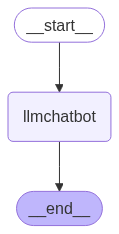

In [39]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [40]:
config={"configurable": {"thread_id": "1"}}

response = graph.invoke({"messages": "Hi, my name is Sathsara."}, config=config)
response['messages'][-1].content

"Nice to meet you, Sathsara! It's great to have you here. Is there something I can help you with, or would you like to chat for a bit?"

In [41]:
config={"configurable": {"thread_id": "2"}}

for chunk in graph.stream({'messages':"Hi, my name is Sathsara."}, config=config, stream_mode="updates"):
    print(chunk)

{'llmchatbot': {'messages': [AIMessage(content="Nice to meet you, Sathsara! It's great that you're here to chat. How's your day going so far?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 19, 'total_tokens': 47, 'completion_time': 0.023743948, 'prompt_time': 0.004114228, 'queue_time': 0.272072061, 'total_time': 0.027858176}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'stop', 'logprobs': None}, id='run--14c19a91-3f0d-4c55-ad7b-73b04b2bd477-0', usage_metadata={'input_tokens': 19, 'output_tokens': 28, 'total_tokens': 47})]}}


In [42]:
for chunk in graph.stream({'messages':"Hi, my name is Sathsara."}, config=config, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi, my name is Sathsara.', additional_kwargs={}, response_metadata={}, id='999f0e9f-9cea-4425-98ae-84ce1162862d'), AIMessage(content="Nice to meet you, Sathsara! It's great that you're here to chat. How's your day going so far?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 19, 'total_tokens': 47, 'completion_time': 0.023743948, 'prompt_time': 0.004114228, 'queue_time': 0.272072061, 'total_time': 0.027858176}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'stop', 'logprobs': None}, id='run--14c19a91-3f0d-4c55-ad7b-73b04b2bd477-0', usage_metadata={'input_tokens': 19, 'output_tokens': 28, 'total_tokens': 47}), HumanMessage(content='Hi, my name is Sathsara.', additional_kwargs={}, response_metadata={}, id='310fd8b2-ab2a-4434-aebf-4420bcf12299')]}
{'messages': [HumanMessage(content='Hi, my name is Sathsara.', additional_kwargs={}, response_metadata={}, id='999

In [43]:
for chunk in graph.stream({'messages':"I am doing good. Can you help me with python coding?"}, config=config, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi, my name is Sathsara.', additional_kwargs={}, response_metadata={}, id='999f0e9f-9cea-4425-98ae-84ce1162862d'), AIMessage(content="Nice to meet you, Sathsara! It's great that you're here to chat. How's your day going so far?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 19, 'total_tokens': 47, 'completion_time': 0.023743948, 'prompt_time': 0.004114228, 'queue_time': 0.272072061, 'total_time': 0.027858176}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'stop', 'logprobs': None}, id='run--14c19a91-3f0d-4c55-ad7b-73b04b2bd477-0', usage_metadata={'input_tokens': 19, 'output_tokens': 28, 'total_tokens': 47}), HumanMessage(content='Hi, my name is Sathsara.', additional_kwargs={}, response_metadata={}, id='310fd8b2-ab2a-4434-aebf-4420bcf12299'), AIMessage(content="Welcome again, Sathsara! I'm happy to chat with you. Is there something on your mind that you'd 

In [46]:
async for event in graph.astream_events({'messages':"I am learning data structures with python."}, config=config):
    print(chunk)

{'messages': [HumanMessage(content='Hi, my name is Sathsara.', additional_kwargs={}, response_metadata={}, id='999f0e9f-9cea-4425-98ae-84ce1162862d'), AIMessage(content="Nice to meet you, Sathsara! It's great that you're here to chat. How's your day going so far?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 19, 'total_tokens': 47, 'completion_time': 0.023743948, 'prompt_time': 0.004114228, 'queue_time': 0.272072061, 'total_time': 0.027858176}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'stop', 'logprobs': None}, id='run--14c19a91-3f0d-4c55-ad7b-73b04b2bd477-0', usage_metadata={'input_tokens': 19, 'output_tokens': 28, 'total_tokens': 47}), HumanMessage(content='Hi, my name is Sathsara.', additional_kwargs={}, response_metadata={}, id='310fd8b2-ab2a-4434-aebf-4420bcf12299'), AIMessage(content="Welcome again, Sathsara! I'm happy to chat with you. Is there something on your mind that you'd 